#### BUSINESS QUESTION: 
“How can we detect emotions from tweets authored by users?”

In [1]:
## Import Libraries
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import string
import spacy
from wordcloud import WordCloud
from collections import Counter
import re
import gensim

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


Bad key "text.kerning_factor" on line 4 in
C:\Users\britn\anaconda3\envs\iod\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## EXPLORING THE DATA

In [2]:
validation = pd.read_csv('../DATA/validation.csv')
train = pd.read_csv('../DATA/training.csv')
test = pd.read_csv('../DATA/test.csv')

print('Dataset information:')
print(f'Training data: {train.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')

Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


In [3]:
validation.head()

text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2
3                  i am just feeling cranky and blue      3
4  i can have for a treat or if i am feeling festive      1

In [4]:
train.head()

text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

In [5]:
test.head()

text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0

In [6]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel

# Defining class names and features
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Combining the 3 DataFrames into a DatasetDict
emotions = DatasetDict({
    "train": Dataset.from_pandas(train, features=features),
    "test": Dataset.from_pandas(test, features=features),
    "validation": Dataset.from_pandas(validation, features=features)})

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
dataframes = [emotions[split].to_pandas() for split in emotions]

In [9]:
for df, split in zip(dataframes, emotions):
    df['split'] = split

In [10]:
df = pd.concat(dataframes, ignore_index=True)

In [11]:
df

text  label       split
0                                i didnt feel humiliated      0       train
1      i can go from feeling so hopeless to so damned...      0       train
2       im grabbing a minute to post i feel greedy wrong      3       train
3      i am ever feeling nostalgic about the fireplac...      2       train
4                                   i am feeling grouchy      3       train
...                                                  ...    ...         ...
19995  im having ssa examination tomorrow in the morn...      0  validation
19996  i constantly worry about their fight against n...      1  validation
19997  i feel its important to share this info for th...      1  validation
19998  i truly feel that if you are passionate enough...      1  validation
19999  i feel like i just wanna buy any cute make up ...      1  validation

[20000 rows x 3 columns]

In [12]:
df.isnull().value_counts()

text   label  split
False  False  False    20000
dtype: int64

In [13]:
df.drop('split', axis=1, inplace=True, errors='ignore')

In [14]:
df.shape

(20000, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [16]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df['label_name'] = df['label'].map(labels_dict )
df.head()

text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger

In [17]:
df[df['text'].str.startswith("i feel")]

text  label label_name
7      i feel as confused about life as a teenager or...      4       fear
9                                    i feel romantic too      2       love
10     i feel like i have to make the suffering i m s...      0    sadness
13                    i feel low energy i m just thirsty      0    sadness
17               i feel pretty pathetic most of the time      0    sadness
...                                                  ...    ...        ...
19992  i feel i should make is how surprised but ente...      5   surprise
19993                           i feel so tortured by it      3      anger
19994  i feel a bit rude leaving you hanging there fr...      3      anger
19997  i feel its important to share this info for th...      1        joy
19999  i feel like i just wanna buy any cute make up ...      1        joy

[6362 rows x 3 columns]

In [18]:
df[df['text'].str.startswith("i didnt feel")]

text  label label_name
0                                i didnt feel humiliated      0    sadness
402    i didnt feel especially nervous in finland but...      4       fear
451    i didnt feel that welcomed when i first entere...      1        joy
819    i didnt feel the cold up there because we had ...      3      anger
1041   i didnt feel like anyone really hated me or no...      0    sadness
...                                                  ...    ...        ...
16311  i didnt feel at all deprived having it in my c...      0    sadness
18089                                i didnt feel rushed      3      anger
18109  i didnt feel all too devastated until i saw pe...      0    sadness
18572  i didnt feel like explaining to her that im ge...      5   surprise
19177     i didnt feel as if i impressed the motherlover      5   surprise

[70 rows x 3 columns]

In [19]:
df.label_name.value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label_name, dtype: int64

## EDA - LOOKING FOR KEY INSIGHTS

In [20]:
count = df.label_name.value_counts()

In [21]:
import plotly.express as px

In [22]:
fig = px.pie(count, names=count.index, values=count.values, title='Emotion Distribution')
fig.show()

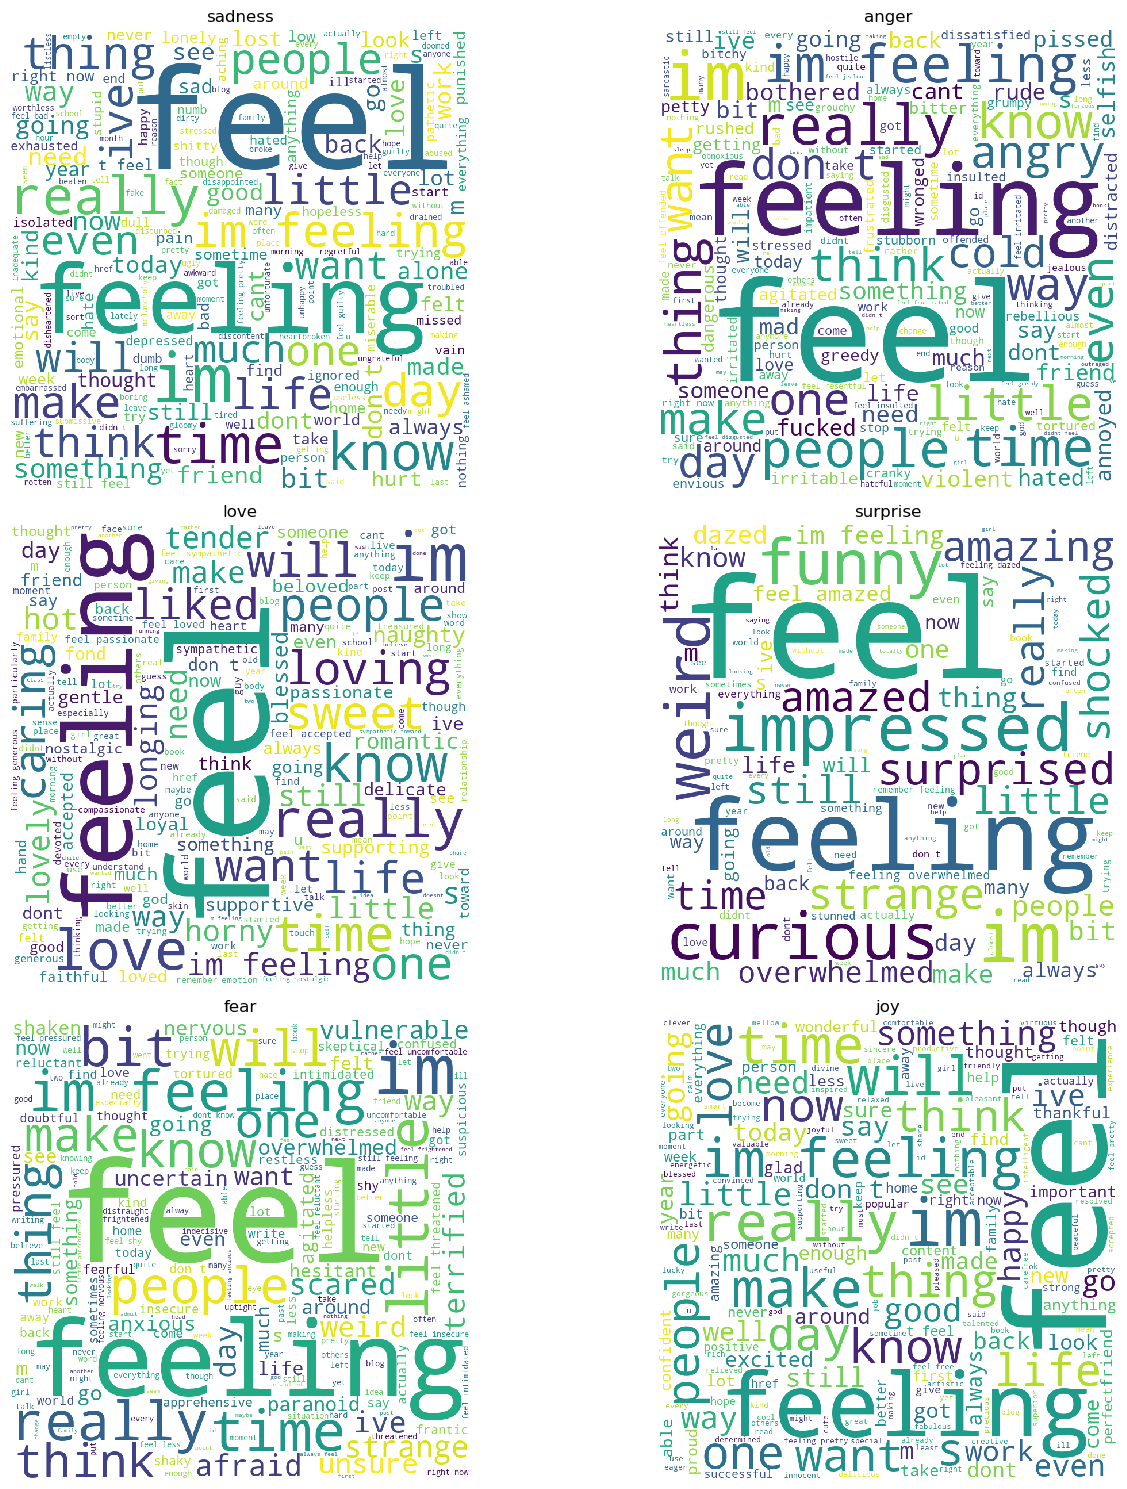

In [23]:
feelings = df.label_name.unique().tolist()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for ax, label_name in zip(axes.flatten(), feelings):
    
    text = " ".join(df[df['label_name'] == label_name]['text'].tolist())
    cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
    ax.imshow(cloud)
    
    
    ax.set_title(label_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

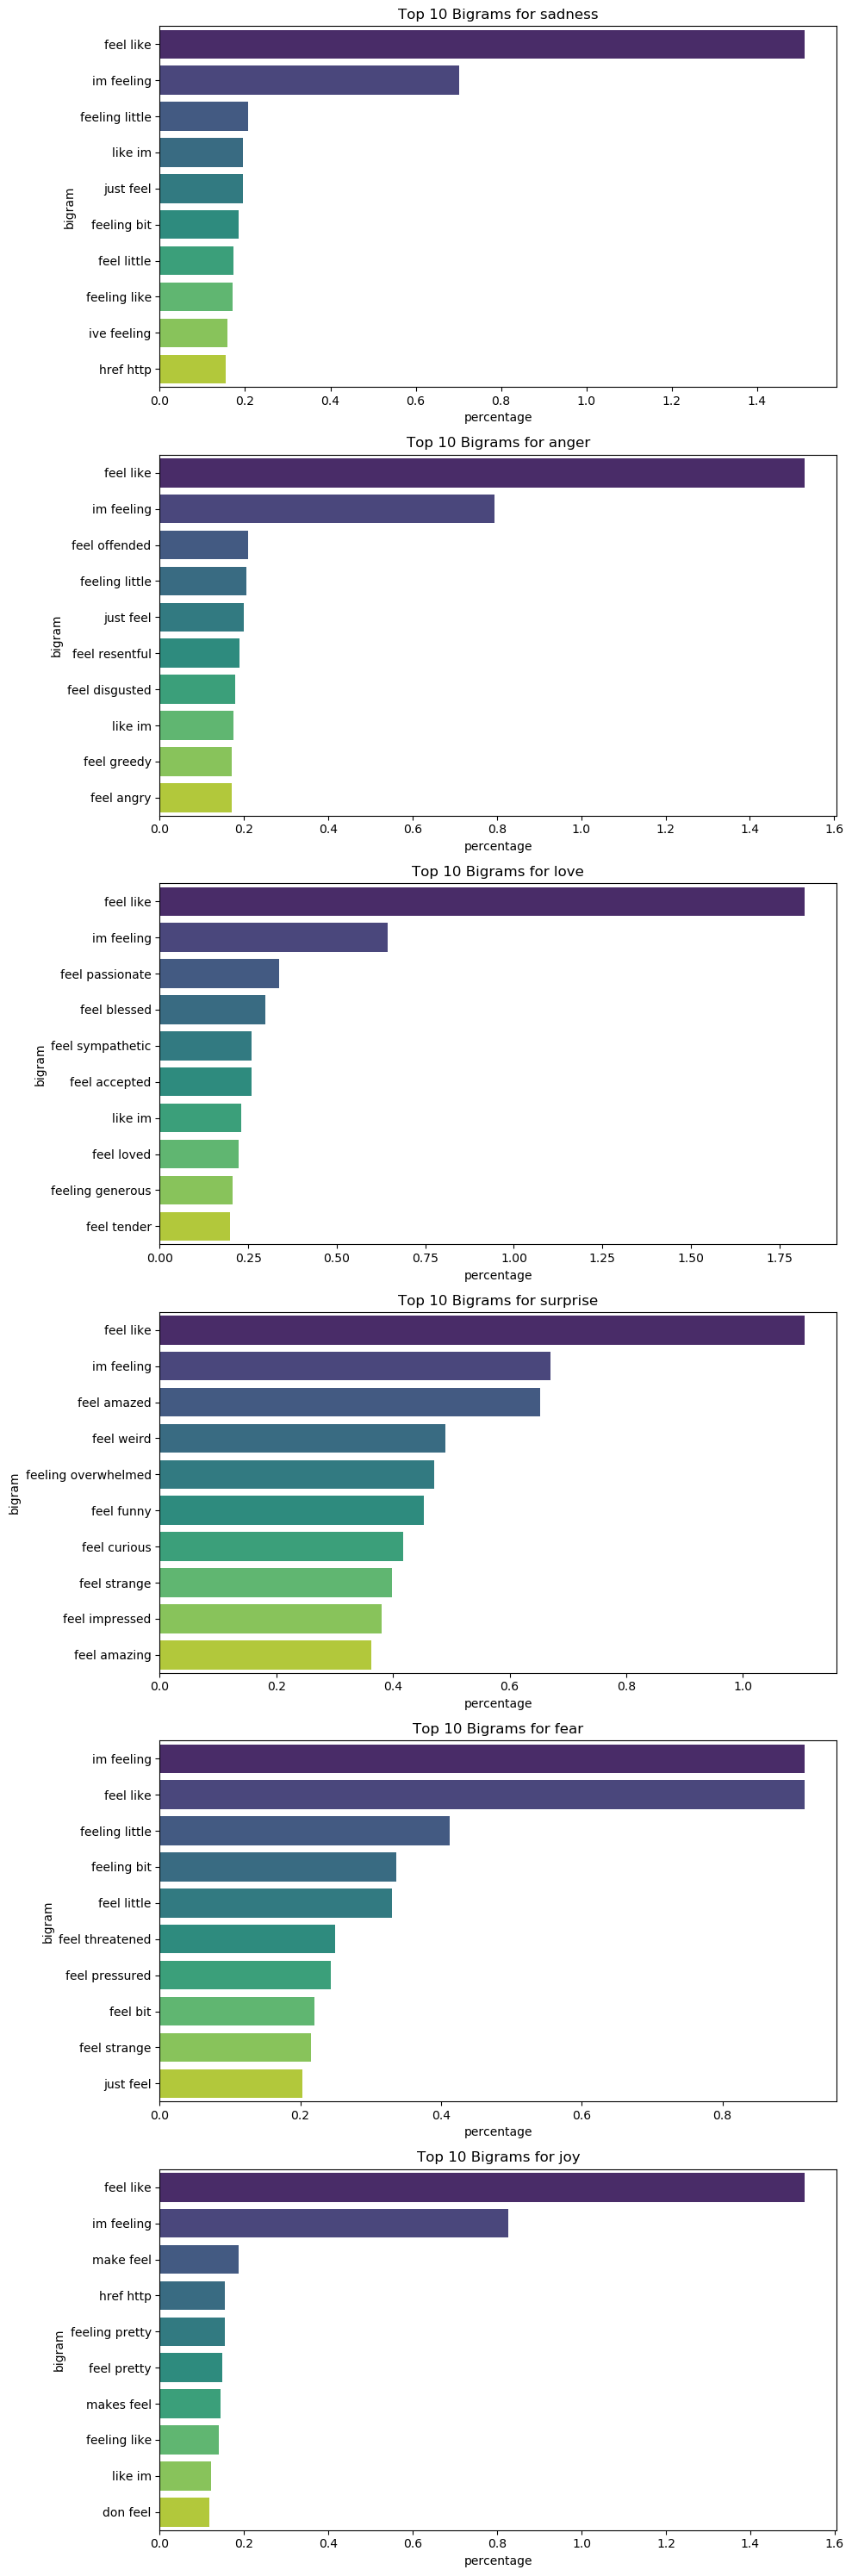

In [24]:
# Create a figure for subplots
emotional = df['label_name'].unique()
emotionum = len(emotional)
fig, axes = plt.subplots(nrows=emotionum, figsize=(10, 5 * emotionum))

for ax, label in zip(axes, emotional):
    # Filter data by label
    sub_df = df[df['label_name'] == label]
    
    # Bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')  # for trigrams, use ngram_range=(3,3)
    X = vectorizer.fit_transform(sub_df['text'])
    bigrams = vectorizer.get_feature_names_out()
    bigram_counts = X.sum(axis=0).tolist()[0]
    
    # Calculate percentage use of each bigram
    total_bigrams = sum(bigram_counts)
    bigram_percentages = [(count / total_bigrams) * 100 for count in bigram_counts]
    
    # 10 Bigrams
    bigram_df = pd.DataFrame({'bigram': bigrams, 'percentage': bigram_percentages})
    bigram_df = bigram_df.sort_values(by='percentage', ascending=False).head(10)
    
    # Plotting
    sns.barplot(x='percentage', y='bigram', data=bigram_df, ax=ax, palette='viridis')
    ax.set_title(f'Top 10 Bigrams for {label}')

plt.tight_layout()
plt.show()

In [25]:
df[df['text'].str.contains("href http")]

text  label label_name
323    i stopped feeling so exhausted a href http pro...      0    sadness
462                  i feel so dazed a href http twitter      5   surprise
866    i feel unwelcome at work sometimes and think p...      0    sadness
967                         i a href http feeling groggy      0    sadness
1162   i really feel that we are progressing towards ...      1        joy
...                                                  ...    ...        ...
19692  i feel isolated and overwhelmed this lie can c...      0    sadness
19697               i feel horny tonight a href http www      2       love
19751  i was feeling hesitant to part with any more m...      4       fear
19770  i feel a little vain i guess but last time i d...      0    sadness
19848  i feel like it title share on reddit reddit a ...      0    sadness

[203 rows x 3 columns]

In [26]:
df['text'] = df['text'].str.replace("href http", "", regex=False)

In [27]:
df['text'] = df['text'].str.replace("don feel", "dont feel", regex=False)

In [28]:
df[df['text'].str.contains("dont feel")]

text  label label_name
724    i feel numb right now i thought i was feeling ...      0    sadness
771    i have an ironic feel i dont feel anything spe...      1        joy
785    i dont feel inhibited and i can work out my pr...      0    sadness
810    i was feeling so overwhelmed that i asked my b...      5   surprise
940    i make new friends in the process i dont feel ...      2       love
1273   i had ritz crackers in my desk drawer because ...      0    sadness
1398   i am feeling generous so you can pick any reas...      1        joy
1792   i feel sad i will just ignore and pretend i do...      0    sadness
2474   i feel more satisfied with what i eat i feel f...      1        joy
4169   i dont feel as carefree as i used to and this ...      1        joy
4400   i also find that during those times when i fee...      0    sadness
4404   i dont want to pretend i am someone and i am n...      1        joy
4879   i really dont feel very sociable in that bar a...      1        joy
5183   im feeling annoyed to add on i dont feel impor...      3      anger
6302   i dont forget it i embrace it i dont feel pity...      1        joy
6486   ive been resting and feeling generally unpleas...      0    sadness
6658   i feel like there are as many theories about t...      1        joy
6661   i feel extremely needy though i dont feel this...      0    sadness
6924   i havent been measuring out food drinking near...      4       fear
7039   i feel selfish on the days i dont feel well an...      3      anger
7293   i have been feeling grumpy for the past few da...      3      anger
7859   i feel like my parents and i are the only ones...      1        joy
8402   i feel it isnt enough times i dont feel respec...      1        joy
8547   i wake up feeling all beaten up and i dont fee...      0    sadness
9139   i feel nervous i dont feel super confident tha...      4       fear
9571   i dont read into traditions because i love the...      3      anger
9579   i dont want her to beg at my feet but a how ar...      0    sadness
10305  i dont want to sound cocky or full of myself b...      0    sadness
10510  i empathize with the feeling of being dissatis...      3      anger
10971  i am feeling as though i am doing something wo...      1        joy
12326  im feeling too stressed doing homework that i ...      0    sadness
12862  i feel melancholy always the period plus just ...      0    sadness
12898  i dont have a god to turn to doesnt mean i don...      3      anger
13454  i dont feel the need to be truthful its comple...      1        joy
13624  i dont want the big buttons simply as i dont f...      3      anger
14732  i did feel sympathy for him and liked him more...      2       love
15756  i still dont feel like finishing typing about ...      2       love
16678  i feel like i have all these cute things but i...      1        joy
17202  i started feeling a little funny but this was ...      5   surprise
17934  i dont really care and i dont feel proud of my...      1        joy
18292  i can say is that i feel like myself when i pu...      2       love
18569  i accept the medication until i dont feel too ...      0    sadness
18732  i feel less weird about soliciting guys for th...      5   surprise
19710  i feel i cant breathe at times but its the cut...      1        joy
19816  i am feeling overwhelmed i dont feel hopeless ...      5   surprise

### PREPROCESSING DATA

In [29]:
# Features and Labels
X = df['text']
y = df['label']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
import contractions

In [32]:
from nltk.corpus import stopwords

In [33]:
from nltk.tokenize import word_tokenize

In [34]:
# Contractions
def expand_contractions(text):
    return contractions.fix(text)

# Applying the function to your DataFrame
df['text'] = df['text'].apply(expand_contractions)

df

text  label label_name
0                              i did not feel humiliated      0    sadness
1      i can go from feeling so hopeless to so damned...      0    sadness
2      i am grabbing a minute to post i feel greedy w...      3      anger
3      i am ever feeling nostalgic about the fireplac...      2       love
4                                   i am feeling grouchy      3      anger
...                                                  ...    ...        ...
19995  i am having ssa examination tomorrow in the mo...      0    sadness
19996  i constantly worry about their fight against n...      1        joy
19997  i feel its important to share this info for th...      1        joy
19998  i truly feel that if you are passionate enough...      1        joy
19999  i feel like i just want to buy any cute make u...      1        joy

[20000 rows x 3 columns]

In [35]:
# Stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return " ".join(filtered_text)

# Apply the function to remove stopwords
df['text'] = df['text'].apply(remove_stopwords)

df

text  label label_name
0                                        feel humiliated      0    sadness
1      go feeling hopeless damned hopeful around some...      0    sadness
2                 grabbing minute post feel greedy wrong      3      anger
3      ever feeling nostalgic fireplace know still pr...      2       love
4                                        feeling grouchy      3      anger
...                                                  ...    ...        ...
19995  ssa examination tomorrow morning quite well pr...      0    sadness
19996  constantly worry fight nature push limits inne...      1        joy
19997         feel important share info experience thing      1        joy
19998  truly feel passionate enough something stay tr...      1        joy
19999   feel like want buy cute make see online even one      1        joy

[20000 rows x 3 columns]

In [36]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(df['text'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
Wall time: 453 ms


In [37]:
X_train_tfidf

<16000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 127481 stored elements in Compressed Sparse Row format>

In [38]:
X_test_tfidf

<4000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 31099 stored elements in Compressed Sparse Row format>

In [39]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_test)

In [40]:
results = pd.DataFrame(columns = ['WordLevel TF-IDF','N-Gram Vectors'])

In [41]:
results

Empty DataFrame
Columns: [WordLevel TF-IDF, N-Gram Vectors]
Index: []

In [42]:
df

text  label label_name
0                                        feel humiliated      0    sadness
1      go feeling hopeless damned hopeful around some...      0    sadness
2                 grabbing minute post feel greedy wrong      3      anger
3      ever feeling nostalgic fireplace know still pr...      2       love
4                                        feeling grouchy      3      anger
...                                                  ...    ...        ...
19995  ssa examination tomorrow morning quite well pr...      0    sadness
19996  constantly worry fight nature push limits inne...      1        joy
19997         feel important share info experience thing      1        joy
19998  truly feel passionate enough something stay tr...      1        joy
19999   feel like want buy cute make see online even one      1        joy

[20000 rows x 3 columns]

### MODELLING

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

##### Random Forest

In [44]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier()

##### Support Vector Machine

In [45]:
SVC = OneVsRestClassifier(LinearSVC())
SVC.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LinearSVC())

##### Logistic Regression

In [46]:
logreg = OneVsRestClassifier(LogisticRegression())
logreg.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

##### KNeighbors Classifier

In [47]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

##### Gradient Boosting Classifier

In [48]:
gbc = OneVsRestClassifier(GradientBoostingClassifier())
gbc.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier())

##### Multinomial Naives Bayes

In [49]:
mnb = OneVsRestClassifier(MultinomialNB())
mnb.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

###### Put the models in a dictionary

In [50]:
param_grid = [
    {
        'clf': [rf_classifier],
        'clf__n_estimators': [100, 200, 300,400],
        'clf__max_depth': [None, 5, 10,15],
    },
    {
        'clf': [SVC],
        'clf__kernel': ['linear', 'rbf'],
        'clf__C': [0.01,0.1, 1, 10],
    },
    {
        'clf': [logreg],
        'clf__solver': ['liblinear', 'lbfgs'],
        'clf__C': [0.01,0.1, 1, 10],
    },
    {
        'clf': [knn],
        'clf__n_neighbors': [3, 5, 7,9],
    },
    {
        'clf': [gbc],
        'clf__n_estimators': [100, 200, 300,400],
        'clf__learning_rate': [0.01, 0.1, 1],
    },
    {
        'clf': [mnb],
        'clf__estimator__alpha': [1.0, 0.1, 0.01, 0.001],
    }
]

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
# Define your models here
models = [
    ('Random Forest', rf_classifier),
    ('Support Vector Machine', SVC),
    ('Logistic Regression', logreg),
    ('KNeighbors', knn),
    ('Gradient Boosting', gbc),
    ('Multinomial Naive Bayes', mnb)
]

# Create a pipeline template with a dummy classifier and scoring
pipeline = Pipeline([
    ('clf', RandomForestClassifier())  # Use a dummy classifier for now
])

# Define the hyperparameter grid for grid search
param_grid = {
    'clf': [model for _, model in models],
    # Add hyperparameters for each classifier here
    # Example: 'clf__param_name': [param_value1, param_value2],
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Create a list to store accuracy scores and model names
model_accuracies = []

for name, model in models:
    # Create a new pipeline with the specified classifier
    pipeline = Pipeline([
        ('clf', model)
    ])
    
    # Fit the pipeline on training data and make predictions on test data
    pipeline.fit(X_train_tfidf, y_train)
    y_pred = pipeline.predict(X_test_tfidf)
    
    # Calculate accuracy and append to the list
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append((name, accuracy))

# Create a figure to display the comparison chart
fig = go.Figure(data=go.Bar(x=[name for name, _ in model_accuracies], y=[acc for _, acc in model_accuracies]))
fig.update_layout(title='Comparison of Models',
                  xaxis=dict(title='Models'),
                  yaxis=dict(title='Accuracy Score'))
fig.show()

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assume y_true is your ground truth labels and y_pred are the predicted labels
y_true = y_test
y_pred = rf_classifier.predict(X_test_tfidf)

# Example metrics calculation
precision = precision_score(y_true, y_pred, average='macro') 
recall = recall_score(y_true, y_pred, average='macro') 
f1 = f1_score(y_true, y_pred, average='macro') 

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.87
Recall: 0.86
F1 Score: 0.86


In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assume y_true is your ground truth labels and y_pred are the predicted labels
y_true = y_test
y_pred = SVC.predict(X_test_tfidf)

# Example metrics calculation
precision = precision_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
recall = recall_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
f1 = f1_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.88
Recall: 0.86
F1 Score: 0.87


In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assume y_true is your ground truth labels and y_pred are the predicted labels
y_true = y_test
y_pred = logreg.predict(X_test_tfidf)

# Example metrics calculation
precision = precision_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
recall = recall_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
f1 = f1_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.89
Recall: 0.78
F1 Score: 0.82


In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assume y_true is your ground truth labels and y_pred are the predicted labels
y_true = y_test
y_pred = knn.predict(X_test_tfidf)

# Example metrics calculation
precision = precision_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
recall = recall_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
f1 = f1_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.79
Recall: 0.74
F1 Score: 0.76


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assume y_true is your ground truth labels and y_pred are the predicted labels
y_true = y_test
y_pred = gbc.predict(X_test_tfidf)

# Example metrics calculation
precision = precision_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
recall = recall_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
f1 = f1_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.86
Recall: 0.81
F1 Score: 0.83


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assume y_true is your ground truth labels and y_pred are the predicted labels
y_true = y_test
y_pred = mnb.predict(X_test_tfidf)

# Example metrics calculation
precision = precision_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
recall = recall_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'
f1 = f1_score(y_true, y_pred, average='macro') # or 'micro' or 'weighted'

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.90
Recall: 0.64
F1 Score: 0.68


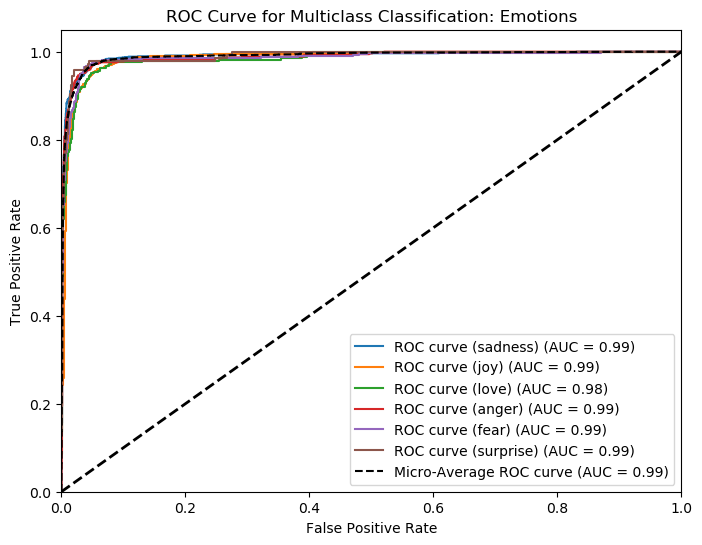

In [58]:
# Import necessary libraries
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Create a dictionary to map class labels to emotions
class_emotion_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Create a OneVsRestClassifier with your SVC model
SVM = OneVsRestClassifier(SVC(probability=True))

# Train the OneVsRest classifier
SVM.fit(X_train_tfidf, y_train)

# Get the decision scores for each class
y_scores = SVM.predict_proba(X_test_tfidf)

# Initialize variables to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(class_emotion_mapping)  # Number of classes based on your mapping

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class with labels
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_emotion_mapping[i]}) (AUC = {roc_auc[i]:.2f})')

# Calculate the micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='k', linestyle='--', label=f'Micro-Average ROC curve (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification: Emotions')
plt.legend(loc='lower right')

plt.show()

In [59]:
from sklearn.metrics import accuracy_score

# Assuming you have already trained your SVM model and have the predicted labels
y_pred = SVM.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of the SVM model: {accuracy:.2f}')

Accuracy of the SVM model: 0.90
